# **K-Fold Cross-Validation on original and rebalanced dataset**

### **colab validation**

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#import os
#os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/COMP6471-IS"

In [ ]:
#changing the working directory
#%cd /content/gdrive/My Drive/COMP6471-IS
#Check the present working directory using pwd command

/content/gdrive/My Drive/COMP6471-IS


In [ ]:
# Download dataset from https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset
#!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset
# download cifar dataset for non-human object
#!kaggle datasets download -d swaroopkml/cifar10-pngs-in-folders
# https://course.fast.ai/datasets#image-classification
#!kaggle datasets download -d bikashjaiswal/dataset-for-mask-nonmask-and-nonhuman-classes

## importing all the necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
from tqdm import tqdm
from statistics import mean
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# pytorch packages
import torch
from torchvision import datasets, models, transforms, utils
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [ ]:
# TO enable GPU. GO to runtime and change runtime type  to 'GPU'. if cuda the GPU is used for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
#!unzip FaceMaskDataset.zip -d dataset
# !unzip small.zip -d small
# !unzip small/Validation/Validation.zip -d temp
#!unzip dataset-for-mask-nonmask-and-nonhuman-classes.zip -d OriginalDataset
# !unzip OriginalData.zip -d OriginalDataset2

## Load the Data, Data pre-processing and Data Augmentation

1.   Normalization of all train, test, and validation dataset
2.   Augmentation of Train dataset only.

  1.   rescale all the image to 28x28
  2.   rotate, crop, shear the immage





In [ ]:
data_dir = 'dataset'
path = os.path.join(os.getcwd(),'KFold_Dataset')
dataset = datasets.ImageFolder(root=path)

In [ ]:
def get_dataset(mode):
  """
  Returns dataset, used  by dataloader with mode = "Train" or "Test"
  """
  data_transforms = {
    'Train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
  }
  return datasets.ImageFolder(root = path, transform=data_transforms[mode])

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [ ]:
%%time
torch.manual_seed(42)
kfold = KFold(n_splits=10, shuffle=True)
trainloader_folds = []
testloader_folds = []

for fold, (train_ids, test_ids) in tqdm(enumerate(kfold.split(dataset))):

  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

  # Define data loaders for training and testing data in this fold
  trainloader = torch.utils.data.DataLoader(get_dataset("Train"), batch_size=4, sampler=train_subsampler)
  testloader = torch.utils.data.DataLoader(get_dataset("Test"), batch_size=4, sampler=test_subsampler)
  trainloader_folds.append(trainloader)
  testloader_folds.append(testloader)
  class_names = get_dataset("Train").classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

10it [00:00, 15.63it/s]

CPU times: user 257 ms, sys: 32.4 ms, total: 289 ms
Wall time: 650 ms


100%|██████████| 2/2 [00:00<00:00, 826.87it/s]


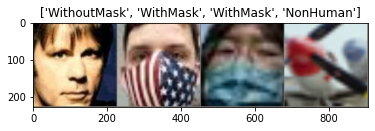

In [ ]:
# Get a batch of first fold of training data
inputs, classes = tqdm(next(iter(trainloader_folds[0])))

# Make a grid from batch
out = utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
lr = 0.01
num_epochs = 4
criterion = nn.CrossEntropyLoss()

def accuracy(y_hat, y):
  pred = torch.argmax(y_hat, dim=1)
  return (pred == y).float().mean()

def train(train_loader, model, optimizer):
    losses = []
    accs = []
    output_labels = np.array([])

    model.train()

    for i, (images, target) in enumerate(tqdm(train_loader, position=0, leave=True)):
        images, target = images.to(device), target.to(device)

        # compute output
        optimizer.zero_grad()

        output = model(images)
        prediction = output.argmax(1)
        output_labels = np.append(output_labels, prediction.cpu().detach().numpy())
        
        # measure accuracy and record loss
        loss = torch.nn.functional.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        acc = accuracy(output, target)

        losses.append(loss.item())
        accs.append(acc.item())

    return losses, accs, output_labels

def test(test_loader, model, optimizer):
    losses = []
    accs = []
    losses_plot = []
    output_labels = np.array([])
    test_labels = np.array([])
    
    model.eval()
    
    for i, (images, target) in enumerate(tqdm(test_loader, position=0, leave=True)):
 
        images, target = images.to(device), target.to(device)
        test_labels = np.append(test_labels, target.cpu().detach().numpy())

        # compute output
        output = model(images)
        prediction = output.argmax(1)
        output_labels = np.append(output_labels, prediction.cpu().detach().numpy())
        
        # measure accuracy and record loss
        loss = torch.nn.functional.cross_entropy(output, target)
        
        acc = accuracy(output, target)
        losses.append(loss.item())
        accs.append(acc.item())
        if i%10 == 0:
          losses_plot.append(loss.item())

    return losses, accs, output_labels, losses_plot, test_labels

Model

In [ ]:
class block(nn.Module):
    def __init__(self, filters, subsample = False):
        super().__init__()
        
        s = 0.5 if subsample else 1.0

        # layers
        self.conv1 = nn.Conv2d(int(filters*s), filters, kernel_size=3, 
                               stride=int(1/s), padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(filters, track_running_stats=True)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(filters, track_running_stats=True)
        self.relu2 = nn.ReLU()
        self.downsample = nn.AvgPool2d(kernel_size=1, stride=2)

        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)   
        
    
    def forward(self, x):
        z = self.conv1(x)
        z = self.bn1(z)
        z = self.relu1(z)
        
        z = self.conv2(z)
        z = self.bn2(z)
        
        # shortcut connection
        if x.shape != z.shape:
            d = self.downsample(x)
            p = torch.mul(d, 0)
            z = z + torch.cat((d, p), dim=1)
        else:
            z = z + x 

        z = self.relu2(z)
        
        return z



class myModel(nn.Module):
    def __init__(self, n):
        super().__init__()
        
        # first layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(64, track_running_stats=True)
        self.relu   = nn.ReLU()
        
        # blocks
        self.block1 = nn.ModuleList([block(64, subsample=False) for _ in range(n)])

        # to speed up the computation
        # self.block21 = block(128, subsample=True)
        # self.block22 = nn.ModuleList([block(128, subsample=False) for _ in range(n-1)])

        # self.block31 = block(256, subsample=True)
        # self.block32 = nn.ModuleList([block(256, subsample=False) for _ in range(n-1)])
        
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.softmax = nn.LogSoftmax(dim=-1)

        # to speed up the computation
        # self.classifier = nn.Sequential(
        #     nn.Dropout(),
        #     nn.Linear(256 , 512),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(512, 3),
        # )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(64 , 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 3),
        )

        
        # initilise weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                m.bias.data.zero_()      
        
        
    def forward(self, x):
        z = self.conv1(x)
        z = self.bn1(z)
        z = self.relu(z)

        for l in self.block1: z = l(z)

        # to speed up the computation
        # z = self.block21(z)
        # for l in self.block22: 
        #     z = l(z)

        # z = self.block31(z)
        # for l in self.block32: 
        #     z = l(z)

        z = self.avgpool(z)
        z = z.view(z.size(0), -1)
        z = self.classifier(z)
        return self.softmax(z)

In [ ]:
my_model = myModel(2)
my_model = my_model.to(device)

# **Evaluation**
Evaluatig the model in terms of accuracy, precision, recall and F1-measure

In [ ]:
def evaluation(index, ytest, ypred, accs):

  # precision
  precision_micro = precision_score(ytest, ypred, average='micro')
  precision_macro = precision_score(ytest, ypred, average='macro')

  # recall
  recall_micro = recall_score(ytest, ypred, average='micro')
  recall_macro = recall_score(ytest, ypred, average='macro')

  # F1 Score
  f1_micro = f1_score(ytest, ypred, average='micro')
  f1_macro = f1_score(ytest, ypred, average='macro')

  acc = round(mean(accs)*100, 2)
  precision_micro = round(precision_micro*100, 2)
  precision_macro = round(precision_macro*100, 2)
  recall_micro = round(recall_micro*100, 2)
  recall_macro = round(recall_macro*100, 2)
  f1_micro = round(f1_micro*100, 2)
  f1_macro = round(f1_macro*100, 2)

  fold = "Fold" + str(index)
  eval_list = [fold]
  eval_list.append(acc)
  eval_list.append(precision_micro) 
  eval_list.append(precision_macro) 
  eval_list.append(recall_micro) 
  eval_list.append(recall_macro)
  eval_list.append(f1_micro) 
  eval_list.append(f1_macro)


  print("------------------ Evaluation ----------------")
  print("Accuracy = " + str(acc) + "%")
  print("Precision Micro = " + str(precision_micro) + "%")
  print("Precision Macro = " + str(precision_macro)+ "%")
  print("Recall Micro = " + str(recall_micro)+ "%")
  print("Recall Macro = " + str(recall_macro)+ "%")
  print("F1 Score Micro = " + str(f1_micro)+ "%")
  print("F1 Score Macro = " + str(f1_macro)+ "%")
    
  return eval_list

def df_row(eval_list):
    
  keys = ["Fold", "Accuracy", "Precision_Micro", "Precision_Macro", "Recall_Micro", "Recall_Macro", "F1_Score_Micro" , "F1_Score_Macro"]
  row_dict = dict(zip(keys, eval_list))
    
  return row_dict

### **Visulaizing loss and Confusion Matrix**

In [ ]:
def plotting(fold, loss, ytest, ypred):

  fig,axs = plt.subplots(1,2,figsize=(14,6))
  axs[0].set_ylim([0, 1.5])
  axs[0].plot(loss, color='orange')
  axs[0].set_title('Test Loss of Fold' + str(fold))
  axs[0].set_xlabel('iteration')
  axs[0].set_ylabel('loss')

  cnf = confusion_matrix(ytest, ypred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cnf, display_labels=class_names)
  disp.plot(ax=axs[1], values_format='')
  disp.ax_.set_title("Test Dataset Confusion Matrix of Fold" + str(fold))


### **Training and Testing the dataset**

In [ ]:
%%time
lr = 0.01
num_epochs = 6
eval_list = []
plot_info = []

for index, (train_fold) in tqdm(enumerate(trainloader_folds)):

  print("\n\n---------------- Fold" + str(index) + " ----------------")
  optimizer = torch.optim.SGD(my_model.parameters(), lr=lr)
  predicted_labels_train = []
  predicted_labels_test = []
  for epoch in tqdm(range(0, num_epochs),position=0, leave=True):

    # train phase
    print("\n\n epoch: ",epoch+1,"\n Train Phase")
    losses, accs, predicted_labels_train = train(train_fold, my_model, optimizer)
    print("\n   mean of losses:", mean(losses))
    print("\n   mean of accuracies:", mean(accs))

  # test phase
  print("\nTest Phase")
  losses, accs_test, predicted_labels_test, losses_plot, test_labels  = test(testloader_folds[index], my_model, optimizer)
  print("\n   mean of losses:", mean(losses))
  print("\n   mean of accuracies:", mean(accs_test))
  eval = evaluation(index, test_labels, predicted_labels_test, accs_test)
  eval_list.append(eval)
  plot_info.append([losses_plot, test_labels, predicted_labels_test])


  0%|          | 0/422 [00:00<?, ?it/s]



---------------- Fold0 ----------------


 epoch:  1 
 Train Phase


  0%|          | 2/422 [00:00<00:37, 11.05it/s]


   mean of losses: 0.9508190401851848

   mean of accuracies: 0.5941943127962085


 epoch:  2 
 Train Phase


  0%|          | 2/422 [00:00<00:28, 14.53it/s]


   mean of losses: 0.8151327308567496

   mean of accuracies: 0.6445497630331753


 epoch:  3 
 Train Phase


  0%|          | 2/422 [00:00<00:29, 14.14it/s]


   mean of losses: 0.711593713681986

   mean of accuracies: 0.6978672985781991


 epoch:  4 
 Train Phase


  0%|          | 2/422 [00:00<00:30, 13.94it/s]


   mean of losses: 0.7072844315911709

   mean of accuracies: 0.7203791469194313


 epoch:  5 
 Train Phase


  0%|          | 2/422 [00:00<00:30, 13.74it/s]


   mean of losses: 0.6710579442963781

   mean of accuracies: 0.715047393364929


 epoch:  6 
 Train Phase


  0%|          | 0/47 [00:00<?, ?it/s]


   mean of losses: 0.6591535176181398

   mean of accuracies: 0.7334123222748815

Test Phase


  0%|          | 1/422 [00:00<00:42,  9.80it/s]


   mean of losses: 0.4472546581416688

   mean of accuracies: 0.8191489361702128
------------------ Evaluation ----------------
Accuracy = 81.91%
Precision Micro = 81.91%
Precision Macro = 82.59%
Recall Micro = 81.91%
Recall Macro = 81.85%
F1 Score Micro = 81.91%
F1 Score Macro = 81.91%


---------------- Fold1 ----------------


 epoch:  1 
 Train Phase


  0%|          | 2/422 [00:00<00:28, 14.53it/s]


   mean of losses: 0.6649192132373557

   mean of accuracies: 0.726303317535545


 epoch:  2 
 Train Phase


  0%|          | 2/422 [00:00<00:29, 14.02it/s]


   mean of losses: 0.6359036029338554

   mean of accuracies: 0.7417061611374408


 epoch:  3 
 Train Phase


  0%|          | 2/422 [00:00<00:29, 14.48it/s]


   mean of losses: 0.6310931136964056

   mean of accuracies: 0.7434834123222749


 epoch:  4 
 Train Phase


  0%|          | 2/422 [00:00<00:29, 14.40it/s]


   mean of losses: 0.5694105687961688

   mean of accuracies: 0.7778436018957346


 epoch:  5 
 Train Phase


  0%|          | 2/422 [00:00<00:28, 14.58it/s]


   mean of losses: 0.5711336709488343

   mean of accuracies: 0.7766587677725119


 epoch:  6 
 Train Phase


  9%|▊         | 4/47 [00:00<00:01, 36.47it/s]


   mean of losses: 0.5753228532115077

   mean of accuracies: 0.7665876777251185

Test Phase


  0%|          | 2/422 [00:00<00:30, 13.87it/s]


   mean of losses: 0.5078499067495478

   mean of accuracies: 0.8297872340425532
------------------ Evaluation ----------------
Accuracy = 82.98%
Precision Micro = 82.98%
Precision Macro = 87.07%
Recall Micro = 82.98%
Recall Macro = 82.31%
F1 Score Micro = 82.98%
F1 Score Macro = 83.36%


---------------- Fold2 ----------------


 epoch:  1 
 Train Phase


  0%|          | 2/422 [00:00<00:30, 13.88it/s]


   mean of losses: 0.5615598655071868

   mean of accuracies: 0.7778436018957346


 epoch:  2 
 Train Phase


  0%|          | 2/422 [00:00<00:30, 13.75it/s]


   mean of losses: 0.5485212770092049

   mean of accuracies: 0.7802132701421801


 epoch:  3 
 Train Phase


  0%|          | 2/422 [00:00<00:30, 13.89it/s]


   mean of losses: 0.5114143445549347

   mean of accuracies: 0.8009478672985783


 epoch:  4 
 Train Phase


  0%|          | 2/422 [00:00<00:29, 14.00it/s]


   mean of losses: 0.5006966328345487

   mean of accuracies: 0.8110189573459715


 epoch:  5 
 Train Phase


  0%|          | 2/422 [00:00<00:30, 13.99it/s]


   mean of losses: 0.564200111475036

   mean of accuracies: 0.7778436018957346


 epoch:  6 
 Train Phase


  9%|▊         | 4/47 [00:00<00:01, 38.22it/s]


   mean of losses: 0.5048147795271676

   mean of accuracies: 0.792654028436019

Test Phase


  0%|          | 2/422 [00:00<00:29, 14.16it/s]


   mean of losses: 0.3996806327412103

   mean of accuracies: 0.9042553191489362
------------------ Evaluation ----------------
Accuracy = 90.43%
Precision Micro = 90.43%
Precision Macro = 91.13%
Recall Micro = 90.43%
Recall Macro = 90.11%
F1 Score Micro = 90.43%
F1 Score Macro = 90.53%


---------------- Fold3 ----------------


 epoch:  1 
 Train Phase


  0%|          | 2/422 [00:00<00:29, 14.19it/s]


   mean of losses: 0.5014867595842735

   mean of accuracies: 0.7932464454976303


 epoch:  2 
 Train Phase


  0%|          | 2/422 [00:00<00:29, 14.01it/s]


   mean of losses: 0.49429626392986253

   mean of accuracies: 0.8009478672985783


 epoch:  3 
 Train Phase


  0%|          | 2/422 [00:00<00:29, 14.46it/s]


   mean of losses: 0.4906420236237135

   mean of accuracies: 0.8027251184834123


 epoch:  4 
 Train Phase


  0%|          | 2/422 [00:00<00:29, 14.37it/s]


   mean of losses: 0.47843174942685246

   mean of accuracies: 0.818127962085308


 epoch:  5 
 Train Phase


  0%|          | 2/422 [00:00<00:30, 13.66it/s]


   mean of losses: 0.47060825806817314

   mean of accuracies: 0.8116113744075829


 epoch:  6 
 Train Phase


  9%|▊         | 4/47 [00:00<00:01, 37.87it/s]


   mean of losses: 0.4789530091976385

   mean of accuracies: 0.8133886255924171

Test Phase


  0%|          | 2/422 [00:00<00:29, 14.38it/s]


   mean of losses: 0.6295380733431654

   mean of accuracies: 0.7925531914893617
------------------ Evaluation ----------------
Accuracy = 79.26%
Precision Micro = 79.26%
Precision Macro = 83.86%
Recall Micro = 79.26%
Recall Macro = 78.65%
F1 Score Micro = 79.26%
F1 Score Macro = 79.77%


---------------- Fold4 ----------------


 epoch:  1 
 Train Phase


  0%|          | 2/422 [00:00<00:29, 14.19it/s]


   mean of losses: 0.47194319653823547

   mean of accuracies: 0.8104265402843602


 epoch:  2 
 Train Phase


  0%|          | 2/422 [00:00<00:29, 14.25it/s]


   mean of losses: 0.4669191740073652

   mean of accuracies: 0.8145734597156398


 epoch:  3 
 Train Phase


  0%|          | 2/422 [00:00<00:30, 13.71it/s]


   mean of losses: 0.46832950564180786

   mean of accuracies: 0.8157582938388626


 epoch:  4 
 Train Phase


  0%|          | 2/422 [00:00<00:29, 14.08it/s]


   mean of losses: 0.4523621948206382

   mean of accuracies: 0.8293838862559242


 epoch:  5 
 Train Phase


  0%|          | 2/422 [00:00<00:30, 13.98it/s]


   mean of losses: 0.4316405257678004

   mean of accuracies: 0.8317535545023697


 epoch:  6 
 Train Phase


  9%|▊         | 4/47 [00:00<00:01, 35.33it/s]


   mean of losses: 0.4314076013629153

   mean of accuracies: 0.8459715639810427

Test Phase


  0%|          | 2/422 [00:00<00:29, 14.22it/s]


   mean of losses: 0.3822838127454545

   mean of accuracies: 0.8617021276595744
------------------ Evaluation ----------------
Accuracy = 86.17%
Precision Micro = 86.17%
Precision Macro = 88.53%
Recall Micro = 86.17%
Recall Macro = 87.41%
F1 Score Micro = 86.17%
F1 Score Macro = 87.33%


---------------- Fold5 ----------------


 epoch:  1 
 Train Phase


  0%|          | 2/422 [00:00<00:28, 14.58it/s]


   mean of losses: 0.45263370496366545

   mean of accuracies: 0.8252369668246445


 epoch:  2 
 Train Phase


  0%|          | 2/422 [00:00<00:29, 14.37it/s]


   mean of losses: 0.43991403410573143

   mean of accuracies: 0.8228672985781991


 epoch:  3 
 Train Phase


  0%|          | 2/422 [00:00<00:31, 13.52it/s]


   mean of losses: 0.4040942305050155

   mean of accuracies: 0.8507109004739336


 epoch:  4 
 Train Phase


  0%|          | 2/422 [00:00<00:29, 14.16it/s]


   mean of losses: 0.4492469677476486

   mean of accuracies: 0.8169431279620853


 epoch:  5 
 Train Phase


  0%|          | 2/422 [00:00<00:30, 13.55it/s]


   mean of losses: 0.45959736380320027

   mean of accuracies: 0.8151658767772512


 epoch:  6 
 Train Phase


  9%|▊         | 4/47 [00:00<00:01, 37.34it/s]


   mean of losses: 0.4485155926372909

   mean of accuracies: 0.8246445497630331

Test Phase


  0%|          | 2/423 [00:00<00:29, 14.51it/s]


   mean of losses: 0.37932268511305783

   mean of accuracies: 0.8617021276595744
------------------ Evaluation ----------------
Accuracy = 86.17%
Precision Micro = 86.17%
Precision Macro = 88.92%
Recall Micro = 86.17%
Recall Macro = 85.46%
F1 Score Micro = 86.17%
F1 Score Macro = 86.33%


---------------- Fold6 ----------------


 epoch:  1 
 Train Phase


  0%|          | 2/423 [00:00<00:29, 14.36it/s]


   mean of losses: 0.4304369810889376

   mean of accuracies: 0.8291962174940898


 epoch:  2 
 Train Phase


  0%|          | 2/423 [00:00<00:30, 13.78it/s]


   mean of losses: 0.4006697363297215

   mean of accuracies: 0.8463356973995272


 epoch:  3 
 Train Phase


  0%|          | 2/423 [00:00<00:29, 14.19it/s]


   mean of losses: 0.41093698223220543

   mean of accuracies: 0.8339243498817966


 epoch:  4 
 Train Phase


  0%|          | 2/423 [00:00<00:30, 14.02it/s]


   mean of losses: 0.4016498799763849

   mean of accuracies: 0.8475177304964538


 epoch:  5 
 Train Phase


  0%|          | 2/423 [00:00<00:29, 14.23it/s]


   mean of losses: 0.4168652783348346

   mean of accuracies: 0.8421985815602837


 epoch:  6 
 Train Phase


  9%|▊         | 4/47 [00:00<00:01, 35.40it/s]


   mean of losses: 0.4021251666454277

   mean of accuracies: 0.8404255319148937

Test Phase


  0%|          | 2/423 [00:00<00:28, 14.91it/s]


   mean of losses: 0.33228998837318824

   mean of accuracies: 0.8617021276595744
------------------ Evaluation ----------------
Accuracy = 86.17%
Precision Micro = 86.1%
Precision Macro = 87.49%
Recall Micro = 86.1%
Recall Macro = 86.77%
F1 Score Micro = 86.1%
F1 Score Macro = 87.03%


---------------- Fold7 ----------------


 epoch:  1 
 Train Phase


  0%|          | 2/423 [00:00<00:31, 13.33it/s]


   mean of losses: 0.39601871237405367

   mean of accuracies: 0.8433806146572104


 epoch:  2 
 Train Phase


  0%|          | 2/423 [00:00<00:30, 13.79it/s]


   mean of losses: 0.40802444012100253

   mean of accuracies: 0.8404255319148937


 epoch:  3 
 Train Phase


  0%|          | 2/423 [00:00<00:30, 13.81it/s]


   mean of losses: 0.39651265612475345

   mean of accuracies: 0.8469267139479906


 epoch:  4 
 Train Phase


  0%|          | 2/423 [00:00<00:30, 13.94it/s]


   mean of losses: 0.3996391031609289

   mean of accuracies: 0.8421985815602837


 epoch:  5 
 Train Phase


  0%|          | 2/423 [00:00<00:29, 14.31it/s]


   mean of losses: 0.4028070941039011

   mean of accuracies: 0.8457446808510638


 epoch:  6 
 Train Phase


  9%|▊         | 4/47 [00:00<00:01, 37.05it/s]


   mean of losses: 0.41939684481802564

   mean of accuracies: 0.8481087470449172

Test Phase


  0%|          | 2/423 [00:00<00:29, 14.12it/s]


   mean of losses: 0.33454457789342457

   mean of accuracies: 0.8776595744680851
------------------ Evaluation ----------------
Accuracy = 87.77%
Precision Micro = 87.7%
Precision Macro = 89.26%
Recall Micro = 87.7%
Recall Macro = 88.33%
F1 Score Micro = 87.7%
F1 Score Macro = 88.02%


---------------- Fold8 ----------------


 epoch:  1 
 Train Phase


  0%|          | 2/423 [00:00<00:30, 13.68it/s]


   mean of losses: 0.40155616526362037

   mean of accuracies: 0.8445626477541371


 epoch:  2 
 Train Phase


  0%|          | 2/423 [00:00<00:29, 14.20it/s]


   mean of losses: 0.3492652077346723

   mean of accuracies: 0.8611111111111112


 epoch:  3 
 Train Phase


  0%|          | 2/423 [00:00<00:30, 13.76it/s]


   mean of losses: 0.41849720912675065

   mean of accuracies: 0.8380614657210402


 epoch:  4 
 Train Phase


  0%|          | 2/423 [00:00<00:30, 13.70it/s]


   mean of losses: 0.3672608016631247

   mean of accuracies: 0.8546099290780141


 epoch:  5 
 Train Phase


  0%|          | 2/423 [00:00<00:28, 14.58it/s]


   mean of losses: 0.3797944758024648

   mean of accuracies: 0.8427895981087471


 epoch:  6 
 Train Phase


  9%|▊         | 4/47 [00:00<00:01, 36.16it/s]


   mean of losses: 0.3754615998611154

   mean of accuracies: 0.8552009456264775

Test Phase


  0%|          | 2/423 [00:00<00:29, 14.42it/s]


   mean of losses: 0.25400853735652373

   mean of accuracies: 0.9148936170212766
------------------ Evaluation ----------------
Accuracy = 91.49%
Precision Micro = 91.44%
Precision Macro = 91.59%
Recall Micro = 91.44%
Recall Macro = 91.49%
F1 Score Micro = 91.44%
F1 Score Macro = 91.48%


---------------- Fold9 ----------------


 epoch:  1 
 Train Phase


  0%|          | 2/423 [00:00<00:28, 14.70it/s]


   mean of losses: 0.35137893399994286

   mean of accuracies: 0.8687943262411347


 epoch:  2 
 Train Phase


  0%|          | 2/423 [00:00<00:30, 13.96it/s]


   mean of losses: 0.3884104127923014

   mean of accuracies: 0.8439716312056738


 epoch:  3 
 Train Phase


  0%|          | 2/423 [00:00<00:30, 13.95it/s]


   mean of losses: 0.39301789975582

   mean of accuracies: 0.8421985815602837


 epoch:  4 
 Train Phase


  0%|          | 2/423 [00:00<00:29, 14.18it/s]


   mean of losses: 0.3630028546019402

   mean of accuracies: 0.8617021276595744


 epoch:  5 
 Train Phase


  0%|          | 2/423 [00:00<00:30, 13.95it/s]


   mean of losses: 0.36532402439945627

   mean of accuracies: 0.8634751773049646


 epoch:  6 
 Train Phase


  9%|▊         | 4/47 [00:00<00:01, 37.39it/s]


   mean of losses: 0.36846108771376224

   mean of accuracies: 0.8504728132387707

Test Phase


100%|██████████| 47/47 [00:01<00:00, 35.90it/s]
10it [38:04, 228.41s/it]


   mean of losses: 0.34127914881769644

   mean of accuracies: 0.8882978723404256
------------------ Evaluation ----------------
Accuracy = 88.83%
Precision Micro = 88.77%
Precision Macro = 89.35%
Recall Micro = 88.77%
Recall Macro = 88.83%
F1 Score Micro = 88.77%
F1 Score Macro = 88.93%
CPU times: user 17min 44s, sys: 10min 57s, total: 28min 41s
Wall time: 38min 4s


### **Plotting Loss & Confusion Matrix of entire Folds**

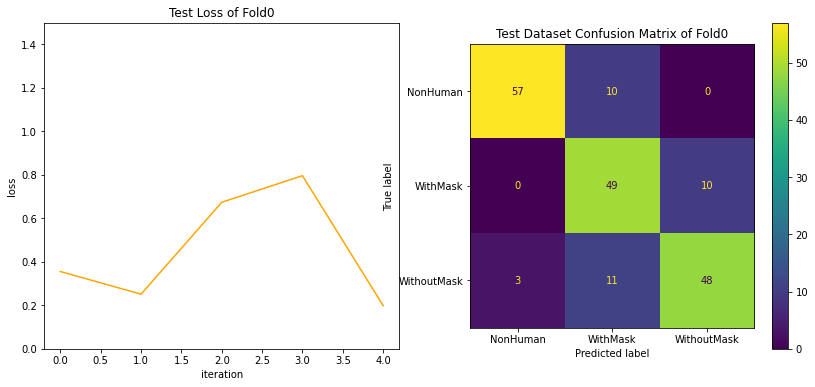

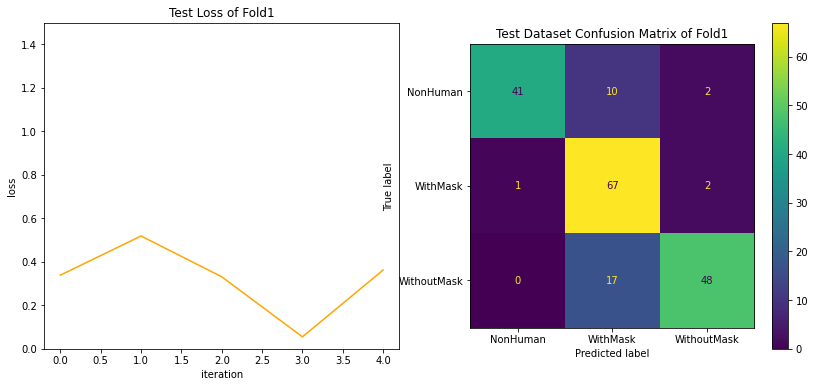

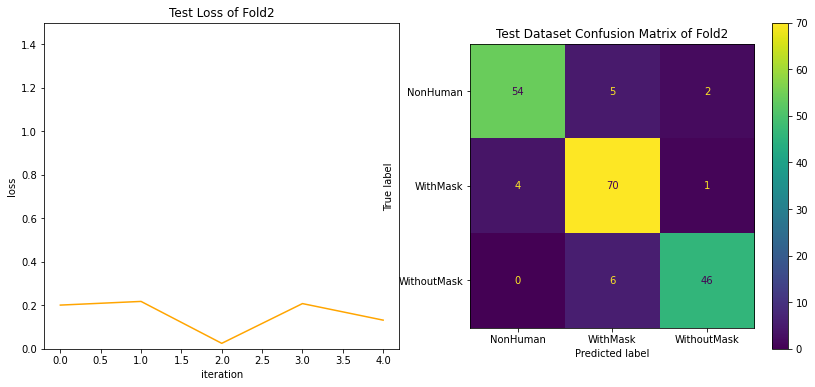

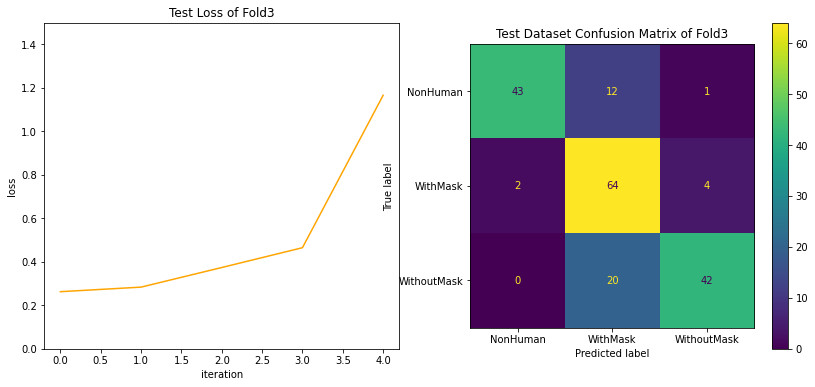

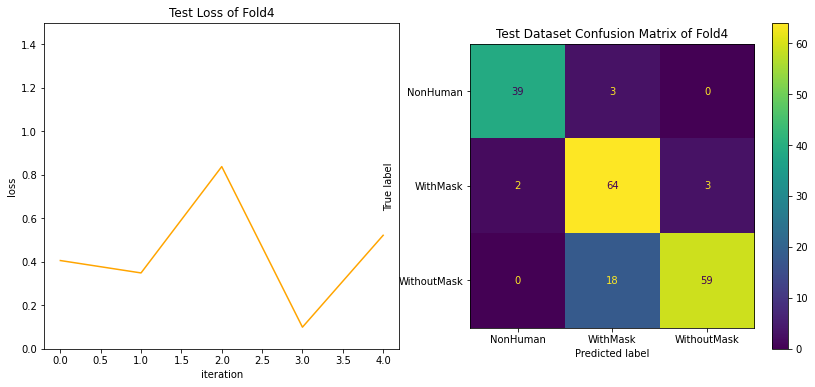

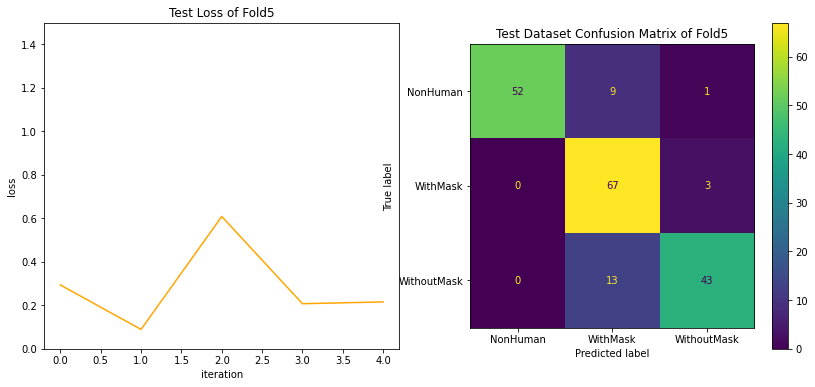

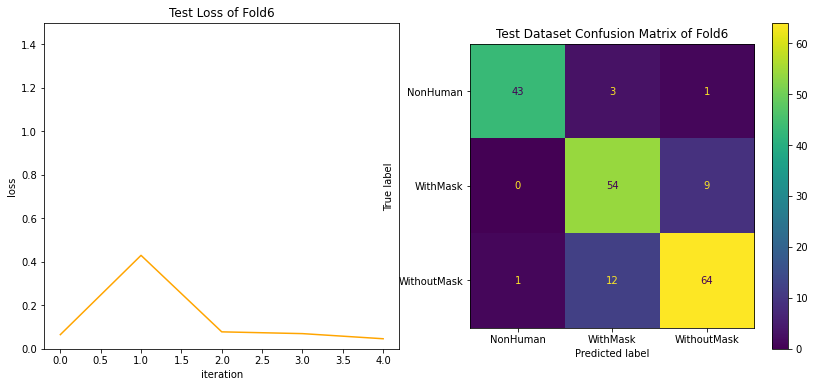

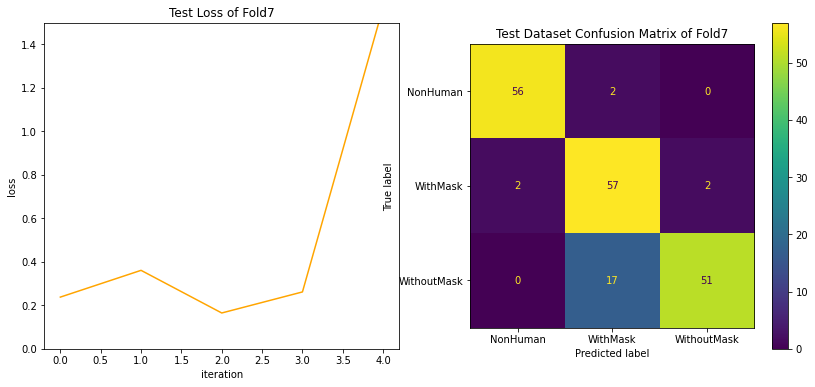

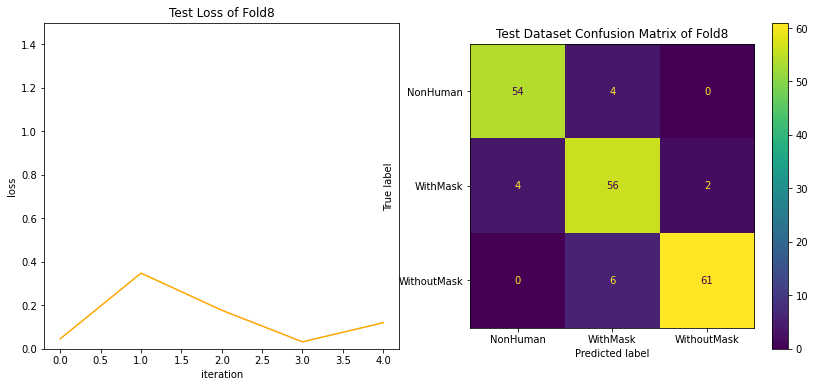

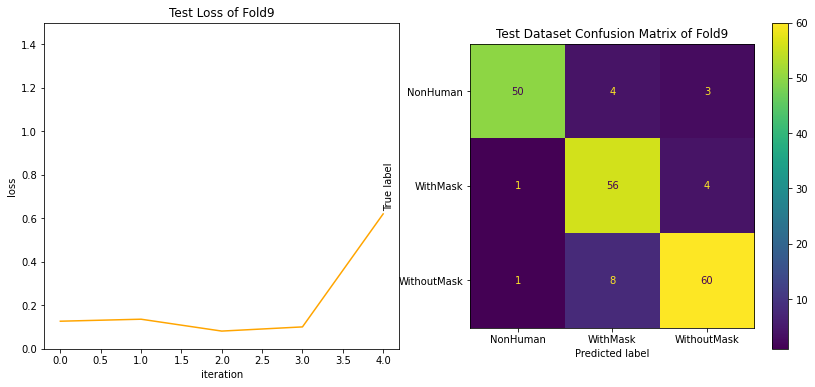

In [ ]:
for index, (item) in enumerate(plot_info):
  plotting(index, item[0], item[1], item[2])

### **Overview of the results**

In [ ]:
pd_data = {'Fold': [], 
           'Accuracy': [], 
           'Precision_Micro': [], 
           'Precision_Macro': [], 
           'Recall_Micro': [], 
           'Recall_Macro': [],
           'F1_Score_Micro': [], 
           'F1_Score_Macro': []}
df = pd.DataFrame(pd_data)

for eval in eval_list:
  df = df.append(df_row(eval), ignore_index=True) 


# Aggregation of results
agg_list = []
agg_list = ["Aggregation"]
agg_list.append(df["Accuracy"].mean())
agg_list.append(df["Precision_Micro"].mean()) 
agg_list.append(df["Precision_Macro"].mean()) 
agg_list.append(df["Recall_Micro"].mean()) 
agg_list.append(df["Recall_Macro"].mean())
agg_list.append(df["F1_Score_Micro"].mean()) 
agg_list.append(df["F1_Score_Macro"].mean())
df = df.append(df_row(agg_list), ignore_index=True)

df

,Fold,Accuracy,Precision_Micro,Precision_Macro,Recall_Micro,Recall_Macro,F1_Score_Micro,F1_Score_Macro
0,Fold0,81.910,81.910,82.590,81.910,81.850,81.910,81.910
1,Fold1,82.980,82.980,87.070,82.980,82.310,82.980,83.360
2,Fold2,90.430,90.430,91.130,90.430,90.110,90.430,90.530
3,Fold3,79.260,79.260,83.860,79.260,78.650,79.260,79.770
4,Fold4,86.170,86.170,88.530,86.170,87.410,86.170,87.330
5,Fold5,86.170,86.170,88.920,86.170,85.460,86.170,86.330
6,Fold6,86.170,86.100,87.490,86.100,86.770,86.100,87.030
7,Fold7,87.770,87.700,89.260,87.700,88.330,87.700,88.020
8,Fold8,91.490,91.440,91.590,91.440,91.490,91.440,91.480
9,Fold9,88.830,88.770,89.350,88.770,88.830,88.770,88.930


## **Performing K-Fold on rebalanced dataset**

In [ ]:
path2 = os.path.join(os.getcwd(),'KFold_BalancedDataset')
dataset2 = datasets.ImageFolder(root=path2)

In [ ]:
def get_dataset2(mode):
  """
  Returns dataset, used  by dataloader with mode = "Train" or "Test"
  """
  data_transforms = {
    'Train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
  }
  return datasets.ImageFolder(root = path2, transform=data_transforms[mode])

In [ ]:
%%time
torch.manual_seed(42)
trainloader_folds2 = []
testloader_folds2 = []

for fold, (train_ids, test_ids) in tqdm(enumerate(kfold.split(dataset2))):

  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

  # Define data loaders for training and testing data in this fold
  trainloader = torch.utils.data.DataLoader(get_dataset2("Train"), batch_size=4, sampler=train_subsampler)
  testloader = torch.utils.data.DataLoader(get_dataset2("Test"), batch_size=4, sampler=test_subsampler)
  trainloader_folds2.append(trainloader)
  testloader_folds2.append(testloader)
  class_names2 = get_dataset2("Train").classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

10it [00:00, 14.30it/s]

CPU times: user 257 ms, sys: 37.6 ms, total: 294 ms
Wall time: 706 ms


100%|██████████| 2/2 [00:00<00:00, 549.86it/s]


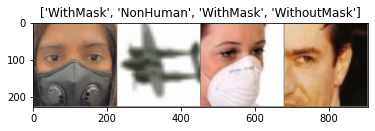

In [ ]:
# Get a batch of first fold of training data
inputs, classes = tqdm(next(iter(trainloader_folds2[0])))

# Make a grid from batch
out = utils.make_grid(inputs)
imshow(out, title=[class_names2[x] for x in classes])

### **Training and Testing the rebalanced dataset**

In [ ]:
%%time
lr = 0.01
num_epochs = 6
eval_list2 = []
plot_info2 = []

for index, (train_fold) in tqdm(enumerate(trainloader_folds2)):

  print("\n\n---------------- Fold" + str(index) + " ----------------")
  optimizer = torch.optim.SGD(my_model.parameters(), lr=lr)
  predicted_labels_train = []
  predicted_labels_test = []
  for epoch in tqdm(range(0, num_epochs),position=0, leave=True):

    # train phase
    print("\n\n epoch: ",epoch+1,"\n Train Phase")
    losses, accs, predicted_labels_train = train(train_fold, my_model, optimizer)
    print("\n   mean of losses:", mean(losses))
    print("\n   mean of accuracies:", mean(accs))

  # test phase
  print("\nTest Phase")
  losses, accs_test, predicted_labels_test, losses_plot, test_labels  = test(testloader_folds2[index], my_model, optimizer)
  print("\n   mean of losses:", mean(losses))
  print("\n   mean of accuracies:", mean(accs_test))
  eval = evaluation(index, test_labels, predicted_labels_test, accs_test)
  eval_list2.append(eval)
  plot_info2.append([losses_plot, test_labels, predicted_labels_test])


  0%|          | 0/431 [00:00<?, ?it/s]



---------------- Fold0 ----------------


 epoch:  1 
 Train Phase


  0%|          | 2/431 [00:00<00:38, 11.16it/s]


   mean of losses: 0.3609965697466774

   mean of accuracies: 0.8526682134570766


 epoch:  2 
 Train Phase


  0%|          | 2/431 [00:00<00:28, 14.99it/s]


   mean of losses: 0.340409112388696

   mean of accuracies: 0.8567285382830626


 epoch:  3 
 Train Phase


  0%|          | 2/431 [00:00<00:28, 14.89it/s]


   mean of losses: 0.3401214901396784

   mean of accuracies: 0.8607888631090487


 epoch:  4 
 Train Phase


  0%|          | 2/431 [00:00<00:29, 14.72it/s]


   mean of losses: 0.3355398235859872

   mean of accuracies: 0.8677494199535963


 epoch:  5 
 Train Phase


  0%|          | 2/431 [00:00<00:29, 14.36it/s]


   mean of losses: 0.3174273106301951

   mean of accuracies: 0.8868909512761021


 epoch:  6 
 Train Phase


  0%|          | 0/48 [00:00<?, ?it/s]


   mean of losses: 0.33877406571829677

   mean of accuracies: 0.872969837587007

Test Phase


  0%|          | 1/431 [00:00<00:43,  9.91it/s]


   mean of losses: 0.28886319196317345

   mean of accuracies: 0.890625
------------------ Evaluation ----------------
Accuracy = 89.06%
Precision Micro = 89.06%
Precision Macro = 90.32%
Recall Micro = 89.06%
Recall Macro = 89.21%
F1 Score Micro = 89.06%
F1 Score Macro = 89.3%


---------------- Fold1 ----------------


 epoch:  1 
 Train Phase


  0%|          | 2/431 [00:00<00:29, 14.66it/s]


   mean of losses: 0.3493354014680654

   mean of accuracies: 0.8694895591647331


 epoch:  2 
 Train Phase


  0%|          | 2/431 [00:00<00:29, 14.74it/s]


   mean of losses: 0.3475528769519206

   mean of accuracies: 0.8578886310904872


 epoch:  3 
 Train Phase


  0%|          | 2/431 [00:00<00:29, 14.66it/s]


   mean of losses: 0.34092990079086505

   mean of accuracies: 0.8625290023201856


 epoch:  4 
 Train Phase


  0%|          | 2/431 [00:00<00:29, 14.44it/s]


   mean of losses: 0.339052519337501

   mean of accuracies: 0.8625290023201856


 epoch:  5 
 Train Phase


  0%|          | 2/431 [00:00<00:31, 13.57it/s]


   mean of losses: 0.33086944353310804

   mean of accuracies: 0.8648491879350348


 epoch:  6 
 Train Phase


  8%|▊         | 4/48 [00:00<00:01, 37.83it/s]


   mean of losses: 0.3311598930894689

   mean of accuracies: 0.872969837587007

Test Phase


  0%|          | 2/431 [00:00<00:28, 14.79it/s]


   mean of losses: 0.2752445599762723

   mean of accuracies: 0.9114583333333334
------------------ Evaluation ----------------
Accuracy = 91.15%
Precision Micro = 91.15%
Precision Macro = 91.33%
Recall Micro = 91.15%
Recall Macro = 90.88%
F1 Score Micro = 91.15%
F1 Score Macro = 91.05%


---------------- Fold2 ----------------


 epoch:  1 
 Train Phase


  0%|          | 2/431 [00:00<00:29, 14.72it/s]


   mean of losses: 0.31002015298504704

   mean of accuracies: 0.8781902552204176


 epoch:  2 
 Train Phase


  0%|          | 2/431 [00:00<00:30, 14.27it/s]


   mean of losses: 0.3343849400146983

   mean of accuracies: 0.8683294663573086


 epoch:  3 
 Train Phase


  0%|          | 2/431 [00:00<00:29, 14.62it/s]


   mean of losses: 0.3170788912502336

   mean of accuracies: 0.8718097447795824


 epoch:  4 
 Train Phase


  0%|          | 2/431 [00:00<00:30, 13.91it/s]


   mean of losses: 0.3276616582266658

   mean of accuracies: 0.8648491879350348


 epoch:  5 
 Train Phase


  0%|          | 2/431 [00:00<00:29, 14.40it/s]


   mean of losses: 0.33719295303049884

   mean of accuracies: 0.8677494199535963


 epoch:  6 
 Train Phase


  8%|▊         | 4/48 [00:00<00:01, 35.50it/s]


   mean of losses: 0.2973340664020029

   mean of accuracies: 0.8880510440835266

Test Phase


  0%|          | 2/431 [00:00<00:30, 14.12it/s]


   mean of losses: 0.3520280650312391

   mean of accuracies: 0.8385416666666666
------------------ Evaluation ----------------
Accuracy = 83.85%
Precision Micro = 83.85%
Precision Macro = 87.85%
Recall Micro = 83.85%
Recall Macro = 83.7%
F1 Score Micro = 83.85%
F1 Score Macro = 84.55%


---------------- Fold3 ----------------


 epoch:  1 
 Train Phase


  0%|          | 2/431 [00:00<00:29, 14.44it/s]


   mean of losses: 0.3140391990369004

   mean of accuracies: 0.8781902552204176


 epoch:  2 
 Train Phase


  0%|          | 2/431 [00:00<00:30, 14.13it/s]


   mean of losses: 0.33012830359934725

   mean of accuracies: 0.8723897911832946


 epoch:  3 
 Train Phase


  0%|          | 2/431 [00:00<00:30, 14.28it/s]


   mean of losses: 0.3345194148988811

   mean of accuracies: 0.8700696055684455


 epoch:  4 
 Train Phase


  0%|          | 2/431 [00:00<00:29, 14.32it/s]


   mean of losses: 0.3103300467989215

   mean of accuracies: 0.8839907192575406


 epoch:  5 
 Train Phase


  0%|          | 2/431 [00:00<00:29, 14.31it/s]


   mean of losses: 0.3235922826339519

   mean of accuracies: 0.8706496519721578


 epoch:  6 
 Train Phase


  8%|▊         | 4/48 [00:00<00:01, 36.75it/s]


   mean of losses: 0.3071542797662024

   mean of accuracies: 0.8799303944315545

Test Phase


  0%|          | 2/431 [00:00<00:33, 12.98it/s]


   mean of losses: 0.25339352420996875

   mean of accuracies: 0.9166666666666666
------------------ Evaluation ----------------
Accuracy = 91.67%
Precision Micro = 91.62%
Precision Macro = 91.87%
Recall Micro = 91.62%
Recall Macro = 91.53%
F1 Score Micro = 91.62%
F1 Score Macro = 91.32%


---------------- Fold4 ----------------


 epoch:  1 
 Train Phase


  0%|          | 2/431 [00:00<00:29, 14.33it/s]


   mean of losses: 0.3043914069454002

   mean of accuracies: 0.8805104408352669


 epoch:  2 
 Train Phase


  0%|          | 2/431 [00:00<00:30, 14.11it/s]


   mean of losses: 0.287426433016021

   mean of accuracies: 0.8851508120649652


 epoch:  3 
 Train Phase


  0%|          | 2/431 [00:00<00:30, 13.88it/s]


   mean of losses: 0.3099448653975212

   mean of accuracies: 0.8851508120649652


 epoch:  4 
 Train Phase


  0%|          | 2/431 [00:00<00:29, 14.33it/s]


   mean of losses: 0.28599874731347724

   mean of accuracies: 0.8822505800464037


 epoch:  5 
 Train Phase


  0%|          | 2/431 [00:00<00:30, 14.28it/s]


   mean of losses: 0.300151176838174

   mean of accuracies: 0.8834106728538283


 epoch:  6 
 Train Phase


  8%|▊         | 4/48 [00:00<00:01, 35.09it/s]


   mean of losses: 0.2770276696166227

   mean of accuracies: 0.8967517401392111

Test Phase


  0%|          | 2/431 [00:00<00:30, 14.23it/s]


   mean of losses: 0.2566953992548709

   mean of accuracies: 0.8958333333333334
------------------ Evaluation ----------------
Accuracy = 89.58%
Precision Micro = 89.53%
Precision Macro = 89.73%
Recall Micro = 89.53%
Recall Macro = 89.88%
F1 Score Micro = 89.53%
F1 Score Macro = 89.77%


---------------- Fold5 ----------------


 epoch:  1 
 Train Phase


  0%|          | 2/431 [00:00<00:30, 13.96it/s]


   mean of losses: 0.2938427131551722

   mean of accuracies: 0.8880510440835266


 epoch:  2 
 Train Phase


  0%|          | 2/431 [00:00<00:30, 13.93it/s]


   mean of losses: 0.29526073047569834

   mean of accuracies: 0.8845707656612529


 epoch:  3 
 Train Phase


  0%|          | 2/431 [00:00<00:30, 13.95it/s]


   mean of losses: 0.3131553160324866

   mean of accuracies: 0.8793503480278422


 epoch:  4 
 Train Phase


  0%|          | 2/431 [00:00<00:29, 14.59it/s]


   mean of losses: 0.308241562564531

   mean of accuracies: 0.8781902552204176


 epoch:  5 
 Train Phase


  0%|          | 2/431 [00:00<00:29, 14.31it/s]


   mean of losses: 0.3010664529960144

   mean of accuracies: 0.8799303944315545


 epoch:  6 
 Train Phase


  8%|▊         | 4/48 [00:00<00:01, 37.17it/s]


   mean of losses: 0.3119643649319727

   mean of accuracies: 0.8723897911832946

Test Phase


  0%|          | 2/431 [00:00<00:29, 14.45it/s]


   mean of losses: 0.36739721451886

   mean of accuracies: 0.890625
------------------ Evaluation ----------------
Accuracy = 89.06%
Precision Micro = 89.01%
Precision Macro = 90.29%
Recall Micro = 89.01%
Recall Macro = 88.83%
F1 Score Micro = 89.01%
F1 Score Macro = 89.36%


---------------- Fold6 ----------------


 epoch:  1 
 Train Phase


  0%|          | 2/431 [00:00<00:30, 14.09it/s]


   mean of losses: 0.2979140852485068

   mean of accuracies: 0.8845707656612529


 epoch:  2 
 Train Phase


  0%|          | 2/431 [00:00<00:29, 14.44it/s]


   mean of losses: 0.30100247772570415

   mean of accuracies: 0.877030162412993


 epoch:  3 
 Train Phase


  0%|          | 2/431 [00:00<00:29, 14.66it/s]


   mean of losses: 0.30188690910489663

   mean of accuracies: 0.8863109048723898


 epoch:  4 
 Train Phase


  0%|          | 2/431 [00:00<00:30, 14.08it/s]


   mean of losses: 0.31005803780660485

   mean of accuracies: 0.8810904872389791


 epoch:  5 
 Train Phase


  0%|          | 2/431 [00:00<00:29, 14.42it/s]


   mean of losses: 0.2891090970211976

   mean of accuracies: 0.8892111368909513


 epoch:  6 
 Train Phase


  8%|▊         | 4/48 [00:00<00:01, 35.99it/s]


   mean of losses: 0.2858853670800852

   mean of accuracies: 0.8938515081206496

Test Phase


  0%|          | 2/431 [00:00<00:30, 13.90it/s]


   mean of losses: 0.38563743435467285

   mean of accuracies: 0.84375
------------------ Evaluation ----------------
Accuracy = 84.38%
Precision Micro = 84.29%
Precision Macro = 85.65%
Recall Micro = 84.29%
Recall Macro = 85.41%
F1 Score Micro = 84.29%
F1 Score Macro = 84.95%


---------------- Fold7 ----------------


 epoch:  1 
 Train Phase


  0%|          | 2/431 [00:00<00:29, 14.40it/s]


   mean of losses: 0.28132087685569707

   mean of accuracies: 0.8857308584686775


 epoch:  2 
 Train Phase


  0%|          | 2/431 [00:00<00:30, 14.14it/s]


   mean of losses: 0.30824812435223065

   mean of accuracies: 0.8781902552204176


 epoch:  3 
 Train Phase


  0%|          | 2/431 [00:00<00:29, 14.53it/s]


   mean of losses: 0.27916712544560257

   mean of accuracies: 0.888631090487239


 epoch:  4 
 Train Phase


  0%|          | 2/431 [00:00<00:30, 14.28it/s]


   mean of losses: 0.2856534792503597

   mean of accuracies: 0.892691415313225


 epoch:  5 
 Train Phase


  0%|          | 2/431 [00:00<00:30, 14.29it/s]


   mean of losses: 0.28206623000689196

   mean of accuracies: 0.8857308584686775


 epoch:  6 
 Train Phase


  8%|▊         | 4/48 [00:00<00:01, 37.10it/s]


   mean of losses: 0.2819419598764375

   mean of accuracies: 0.888631090487239

Test Phase


  0%|          | 2/431 [00:00<00:29, 14.36it/s]


   mean of losses: 0.3119428936236848

   mean of accuracies: 0.8802083333333334
------------------ Evaluation ----------------
Accuracy = 88.02%
Precision Micro = 87.96%
Precision Macro = 88.02%
Recall Micro = 87.96%
Recall Macro = 89.1%
F1 Score Micro = 87.96%
F1 Score Macro = 88.44%


---------------- Fold8 ----------------


 epoch:  1 
 Train Phase


  0%|          | 2/431 [00:00<00:31, 13.69it/s]


   mean of losses: 0.2998193741847357

   mean of accuracies: 0.8909512761020881


 epoch:  2 
 Train Phase


  0%|          | 2/431 [00:00<00:29, 14.59it/s]


   mean of losses: 0.2939361943571619

   mean of accuracies: 0.8880510440835266


 epoch:  3 
 Train Phase


  0%|          | 2/431 [00:00<00:30, 14.29it/s]


   mean of losses: 0.28617335355401974

   mean of accuracies: 0.888631090487239


 epoch:  4 
 Train Phase


  0%|          | 2/431 [00:00<00:28, 14.82it/s]


   mean of losses: 0.2696000365097413

   mean of accuracies: 0.8961716937354989


 epoch:  5 
 Train Phase


  0%|          | 2/431 [00:00<00:30, 14.08it/s]


   mean of losses: 0.2766964115119235

   mean of accuracies: 0.8961716937354989


 epoch:  6 
 Train Phase


  8%|▊         | 4/48 [00:00<00:01, 35.02it/s]


   mean of losses: 0.29135161444108304

   mean of accuracies: 0.8868909512761021

Test Phase


  0%|          | 2/431 [00:00<00:30, 14.01it/s]


   mean of losses: 0.28597051826848957

   mean of accuracies: 0.9166666666666666
------------------ Evaluation ----------------
Accuracy = 91.67%
Precision Micro = 91.62%
Precision Macro = 91.74%
Recall Micro = 91.62%
Recall Macro = 91.92%
F1 Score Micro = 91.62%
F1 Score Macro = 91.68%


---------------- Fold9 ----------------


 epoch:  1 
 Train Phase


  0%|          | 2/431 [00:00<00:30, 14.21it/s]


   mean of losses: 0.27667662882804656

   mean of accuracies: 0.8909512761020881


 epoch:  2 
 Train Phase


  0%|          | 2/431 [00:00<00:29, 14.38it/s]


   mean of losses: 0.2829000793490343

   mean of accuracies: 0.8909512761020881


 epoch:  3 
 Train Phase


  0%|          | 2/431 [00:00<00:29, 14.50it/s]


   mean of losses: 0.2750649550127994

   mean of accuracies: 0.8967517401392111


 epoch:  4 
 Train Phase


  0%|          | 2/431 [00:00<00:29, 14.46it/s]


   mean of losses: 0.2843790656029141

   mean of accuracies: 0.892691415313225


 epoch:  5 
 Train Phase


  0%|          | 2/431 [00:00<00:30, 14.25it/s]


   mean of losses: 0.259745013943318

   mean of accuracies: 0.8961716937354989


 epoch:  6 
 Train Phase


  8%|▊         | 4/48 [00:00<00:01, 36.78it/s]


   mean of losses: 0.2674659625891804

   mean of accuracies: 0.8973317865429234

Test Phase


100%|██████████| 48/48 [00:01<00:00, 36.47it/s]
10it [37:56, 227.63s/it]


   mean of losses: 0.28168164647649974

   mean of accuracies: 0.90625
------------------ Evaluation ----------------
Accuracy = 90.62%
Precision Micro = 90.58%
Precision Macro = 91.68%
Recall Micro = 90.58%
Recall Macro = 90.29%
F1 Score Micro = 90.58%
F1 Score Macro = 90.74%
CPU times: user 17min 55s, sys: 11min 6s, total: 29min 2s
Wall time: 37min 56s


### **Plotting Loss & Confusion Matrix of entire Folds**

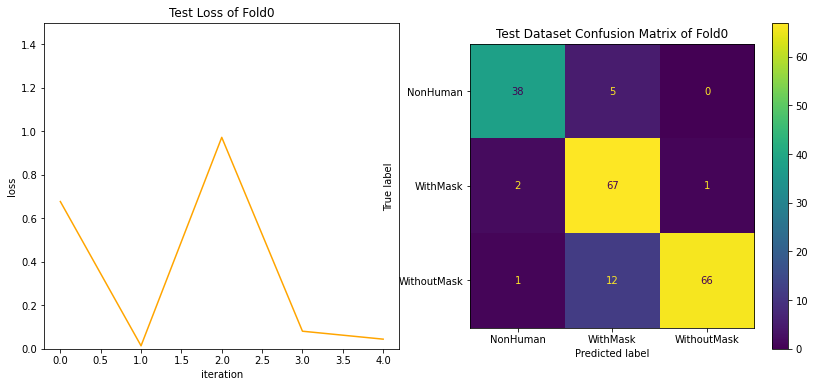

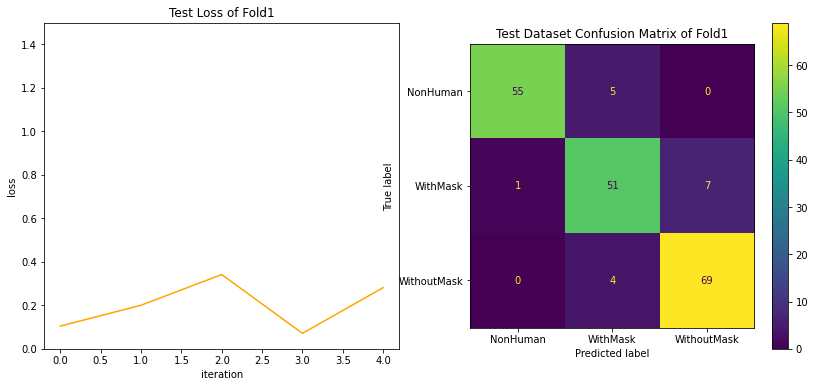

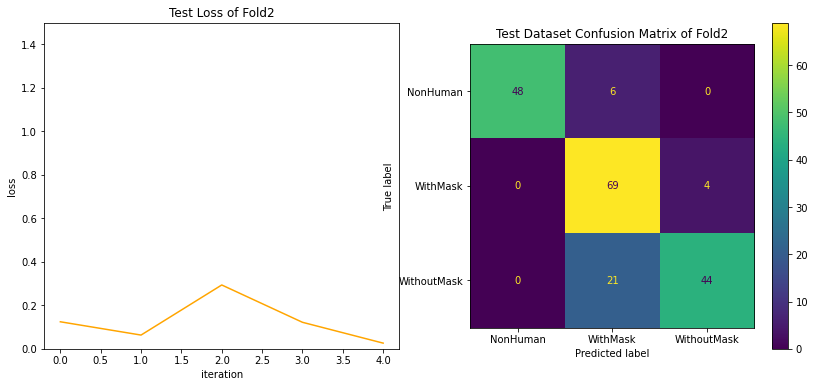

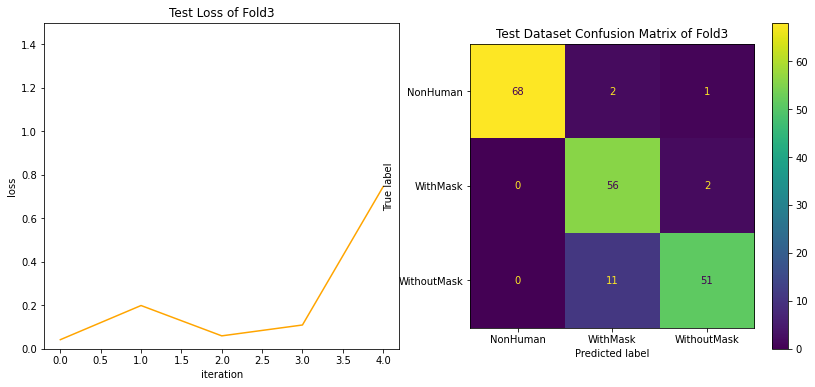

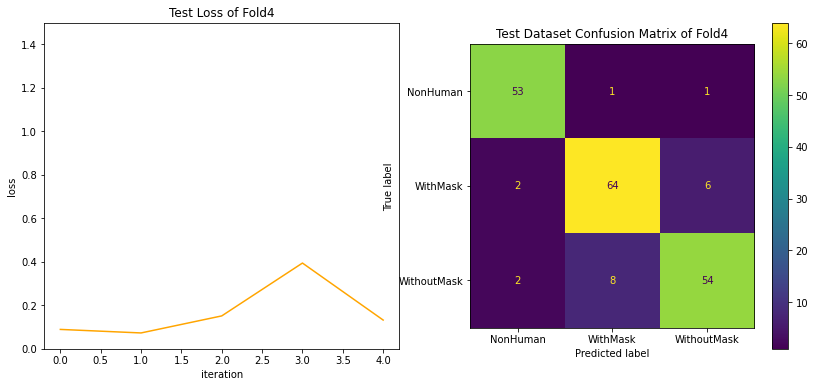

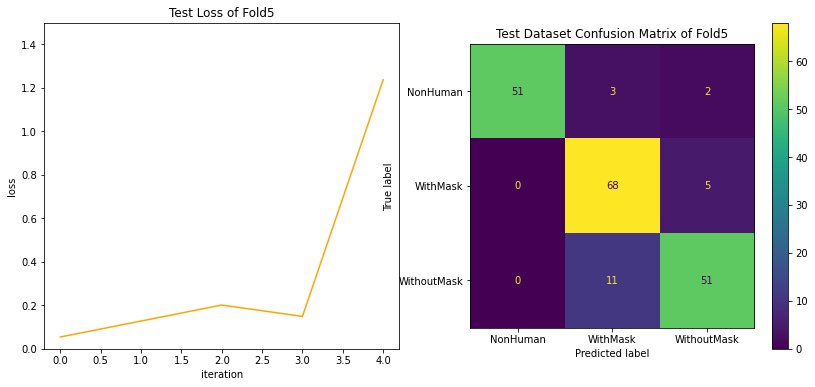

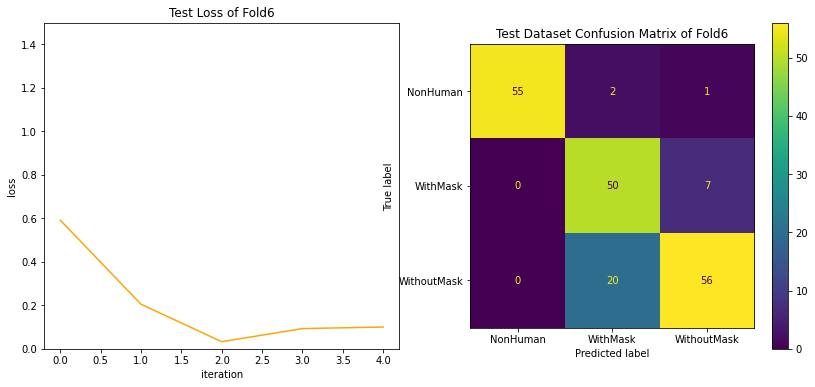

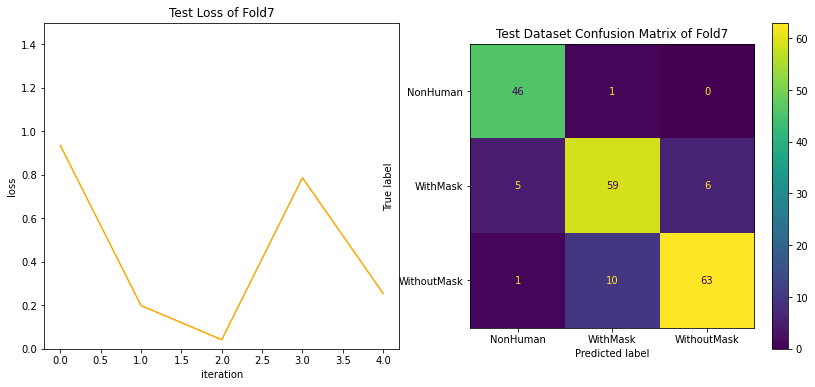

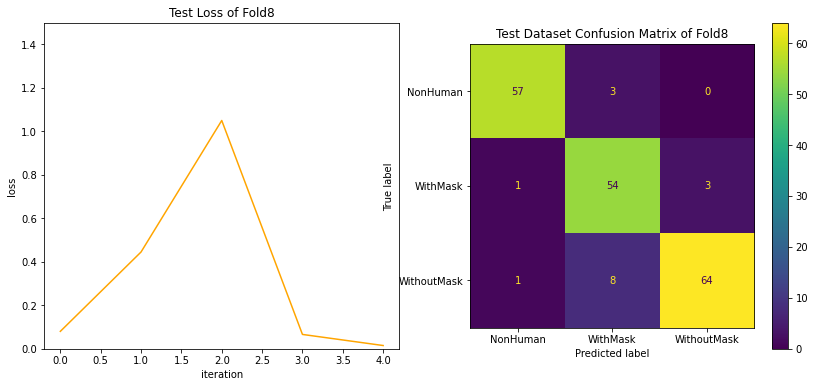

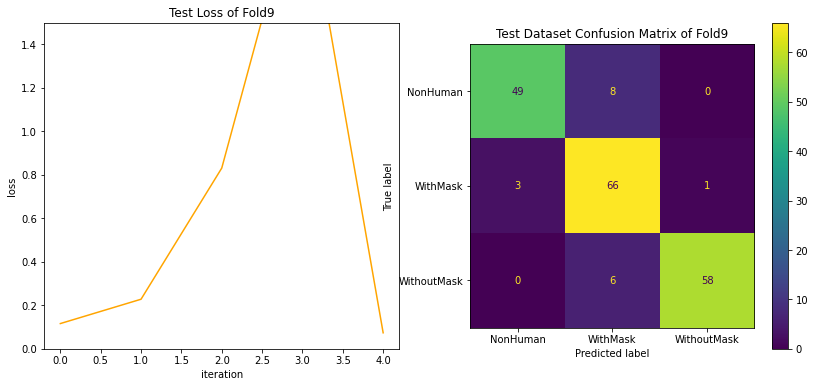

In [ ]:
for index, (item) in enumerate(plot_info2):
  plotting(index, item[0], item[1], item[2])

### **Overview of the results**

In [ ]:
df2 = pd.DataFrame(pd_data)

for eval in eval_list2:
  df2 = df2.append(df_row(eval), ignore_index=True) 


# Aggregation of results
agg_list2 = []
agg_list2 = ["Aggregation"]
agg_list2.append(df2["Accuracy"].mean())
agg_list2.append(df2["Precision_Micro"].mean()) 
agg_list2.append(df2["Precision_Macro"].mean()) 
agg_list2.append(df2["Recall_Micro"].mean()) 
agg_list2.append(df2["Recall_Macro"].mean())
agg_list2.append(df2["F1_Score_Micro"].mean()) 
agg_list2.append(df2["F1_Score_Macro"].mean())
df2 = df2.append(df_row(agg_list2), ignore_index=True)

df2

,Fold,Accuracy,Precision_Micro,Precision_Macro,Recall_Micro,Recall_Macro,F1_Score_Micro,F1_Score_Macro
0,Fold0,89.060,89.060,90.320,89.060,89.210,89.060,89.300
1,Fold1,91.150,91.150,91.330,91.150,90.880,91.150,91.050
2,Fold2,83.850,83.850,87.850,83.850,83.700,83.850,84.550
3,Fold3,91.670,91.620,91.870,91.620,91.530,91.620,91.320
4,Fold4,89.580,89.530,89.730,89.530,89.880,89.530,89.770
5,Fold5,89.060,89.010,90.290,89.010,88.830,89.010,89.360
6,Fold6,84.380,84.290,85.650,84.290,85.410,84.290,84.950
7,Fold7,88.020,87.960,88.020,87.960,89.100,87.960,88.440
8,Fold8,91.670,91.620,91.740,91.620,91.920,91.620,91.680
9,Fold9,90.620,90.580,91.680,90.580,90.290,90.580,90.740
